- langgraph studio
    - https://www.youtube.com/watch?v=pLPJoFvq4_M
- https://github.com/langchain-ai/langgraph/blob/main/examples/reflexion/reflexion.ipynb
- https://github.com/langchain-ai/langgraph/blob/main/examples/agent_executor/force-calling-a-tool-first.ipynb

In [1]:
import os
from typing import TypedDict, Annotated, List, Union, Sequence
import operator
import json
from dotenv import load_dotenv

from langchain import hub
from langchain.tools import BaseTool, StructuredTool, Tool, tool
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_openai.chat_models import ChatOpenAI
from langchain.agents import create_openai_functions_agent
from langchain_core.utils.function_calling import convert_to_openai_function

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, FunctionMessage

from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, ToolInvocation
from langgraph.prebuilt.tool_executor import ToolExecutor

os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'


In [2]:
load_dotenv()

True

## core concepts

In [3]:
from IPython.display import Image

langchain => langgraph
- chain: 更多是 linear chain，链式顺序执行；
    - LCEL
- graph：可以有分支/判断（是否到达 AgentFinish），有循环
    - ReAct（Reasoning & Acting）其实本质上也不是 linear chain 了；

Graph 

- nodes, edges
    - 每个节点都是一个函数
    - 所有节点的输入都是 state，输出会附加一些信息到新的 state 里
- state 沿着 edge 从一个 node 到另一个 node 时，state 会发生变化（携带上一个 node 的执行输出信息）

In [4]:
Image(url='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*bkNjqXR1LjAVJQbNLpfYvA.png', width=500)

## examples 1: Agent Executor

In [5]:
os.environ["LANGCHAIN_PROJECT"] = "lg_01_agent_executor"

In [6]:
class AgentState(TypedDict):
   input: str
   chat_history: list[BaseMessage]
   agent_outcome: Union[AgentAction, AgentFinish, None]
    # 不断追加和传递
   intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

- TypedDict: 静态类型，可以约定 value 类型的字典

### tools

Tools are interfaces that an agent can use to interact with the world. They combine a few things:

- The name of the tool
- A description of what the tool is
- JSON schema of what the inputs to the tool are
- The function to call

In [7]:
import random

@tool("upper_case", return_direct=True)
def to_upper_case(input:str) -> str:
  """Returns the input as all upper case."""
  return input.upper()

@tool("random_number", return_direct=True)
def random_number_maker(input:str) -> str:
    """Returns a random number between 0-100."""
    return random.randint(0, 100)

tools = [to_upper_case,random_number_maker]

In [8]:
random_number_maker.run('random')

15

In [9]:
to_upper_case.run('hello WORLD')

'HELLO WORLD'

### Agent

In [10]:
# https://smith.langchain.com/hub/hwchase17/openai-functions-agent
prompt = hub.pull('hwchase17/openai-functions-agent')
llm = ChatOpenAI(model="gpt-4o", streaming=True)
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'chat_history': []}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-functions-agent', 'lc_hub_commit_hash': 'a1655024b06afbd95d17449f21316291e0726f13dcfaf990cc0d18087ad689a5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplat

In [11]:
agent = create_openai_functions_agent(llm, tools, prompt)

In [12]:
type(agent)

langchain_core.runnables.base.RunnableSequence

In [13]:
inputs = {"input": "give me a random number and then write in words and make it upper case.",
          "chat_history": [],
          "intermediate_steps":[]}

agent_outcome = agent.invoke(inputs)

In [14]:
agent_outcome

AgentActionMessageLog(tool='random_number', tool_input={'input': 'Generate a random number'}, log="\nInvoking: `random_number` with `{'input': 'Generate a random number'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Generate a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-e2652fc2-03db-4c6c-9b26-310d80e0f06a-0')])

### tools

In [15]:
tool_executor = ToolExecutor(tools)
# tool_executor = ToolNode(tools)

/tmp/ipykernel_1802818/3792225135.py:1: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [16]:
def run_agent(state):
    agent_outcome = agent.invoke(state)
    # AgentState.agent_outcome: 当前输出，决策动作
    return {"agent_outcome": agent_outcome}

def execute_tools(state):
    agent_action = state['agent_outcome']
    output = tool_executor.invoke(agent_action)
    print(f"The agent action is {agent_action}")
    print(f"The tool result is: {output}")
    # AgentState.intermediate_steps: 追加逻辑
    return {"intermediate_steps": [(agent_action, str(output))]}

def should_continue(state):
    if isinstance(state['agent_outcome'], AgentFinish):
        return "end"
    return "continue"

### graph

In [17]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

workflow.set_entry_point("agent")

# 条件分支
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)

workflow.add_edge('action', 'agent')

graph = workflow.compile()

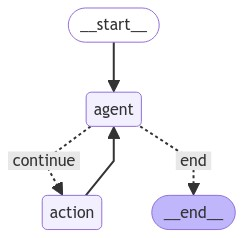

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
workflow.nodes, workflow.edges

({'agent': StateNodeSpec(runnable=agent(recurse=True), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None),
  'action': StateNodeSpec(runnable=action(recurse=True), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None)},
 {('__start__', 'agent'), ('action', 'agent')})

In [20]:
workflow.channels

{'input': <langgraph.channels.last_value.LastValue at 0x77547bb3e0f0>,
 'chat_history': <langgraph.channels.last_value.LastValue at 0x77547bb3dee0>,
 'agent_outcome': <langgraph.channels.last_value.LastValue at 0x77547bb3dfd0>,
 'intermediate_steps': <langgraph.channels.binop.BinaryOperatorAggregate at 0x775484081940>}

In [21]:
inputs = {"input": "give me a random number and then write in words and make it upper case.", 
          "chat_history": []}
for s in graph.stream(inputs):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentActionMessageLog(tool='random_number', tool_input={'input': 'Give me a random number'}, log="\nInvoking: `random_number` with `{'input': 'Give me a random number'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Give me a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-00c69965-ef08-4664-a251-2510db7afcf7-0')])}
----
The agent action is tool='random_number' tool_input={'input': 'Give me a random number'} log="\nInvoking: `random_number` with `{'input': 'Give me a random number'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Give me a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-00c69965

In [39]:
inputs = {"input": "give me a random number and then write in words and make it upper case", "chat_history": []}

output = graph.invoke(inputs)

The agent action is tool='random_number' tool_input={'input': 'Give me a random number'} log="\nInvoking: `random_number` with `{'input': 'Give me a random number'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Give me a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-37b6ccdc-77c5-4af3-bdbf-874d0506622a-0')]
The tool result is: 13
The agent action is tool='upper_case' tool_input={'input': 'thirteen'} log="\nInvoking: `upper_case` with `{'input': 'thirteen'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"thirteen"}', 'name': 'upper_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-d159f4d6-7805-46f4-8029-41c9eaa0e699-0')]
The tool result is: THIRTEE

In [40]:
output

{'input': 'give me a random number and then write in words and make it upper case',
 'chat_history': [],
 'agent_outcome': AgentFinish(return_values={'output': 'The random number is 13, which in words is: THIRTEEN'}, log='The random number is 13, which in words is: THIRTEEN'),
 'intermediate_steps': [(AgentActionMessageLog(tool='random_number', tool_input={'input': 'Give me a random number'}, log="\nInvoking: `random_number` with `{'input': 'Give me a random number'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Give me a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-37b6ccdc-77c5-4af3-bdbf-874d0506622a-0')]),
   '13'),
  (AgentActionMessageLog(tool='upper_case', tool_input={'input': 'thirteen'}, log="\nInvoking: `upper_case` with `{'input': 'thirteen'}`\n\n\n", message_log=[AIMessage(content=''

In [41]:
output.get('agent_outcome')

AgentFinish(return_values={'output': 'The random number is 13, which in words is: THIRTEEN'}, log='The random number is 13, which in words is: THIRTEEN')

In [42]:
output.get('agent_outcome').return_values['output']

'The random number is 13, which in words is: THIRTEEN'

In [43]:
output['intermediate_steps']

[(AgentActionMessageLog(tool='random_number', tool_input={'input': 'Give me a random number'}, log="\nInvoking: `random_number` with `{'input': 'Give me a random number'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Give me a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-37b6ccdc-77c5-4af3-bdbf-874d0506622a-0')]),
  '13'),
 (AgentActionMessageLog(tool='upper_case', tool_input={'input': 'thirteen'}, log="\nInvoking: `upper_case` with `{'input': 'thirteen'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"thirteen"}', 'name': 'upper_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-d159f4d6-7805-46f4-8029-41c9eaa0e699-0')]),
  'THIRTEEN')]

## example 2: Chat Executor

In [27]:
os.environ["LANGCHAIN_PROJECT"] = "lg_02_chat_executor"

In [28]:
llm = ChatOpenAI(model="gpt-4o", streaming=True)

In [29]:
functions = [convert_to_openai_function(t) for t in tools]
llm = llm.bind_functions(functions)

In [30]:
functions

[{'name': 'upper_case',
  'description': 'Returns the input as all upper case.',
  'parameters': {'type': 'object',
   'properties': {'input': {'type': 'string'}},
   'required': ['input']}},
 {'name': 'random_number',
  'description': 'Returns a random number between 0-100.',
  'parameters': {'type': 'object',
   'properties': {'input': {'type': 'string'}},
   'required': ['input']}}]

### agent state

In [31]:
class AgentState(TypedDict):
    # 不断追加和传递
    messages: Annotated[Sequence[BaseMessage], operator.add]

### nodes

In [32]:
def should_continue(state):
    messages = state['messages']
    last_message = messages[-1]
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    return "continue"

def call_model(state):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

def call_tool(state):
    messages = state['messages']
    last_message = messages[-1]
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(last_message.additional_kwargs["function_call"]["arguments"]),
    )
    print(f"The agent action is {action}")
    response = tool_executor.invoke(action)
    print(f"The tool result is: {response}")
    function_message = FunctionMessage(content=str(response), name=action.tool)
    return {"messages": [function_message]}

### graph

In [33]:
workflow = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)
workflow.add_edge('action', 'agent')
graph2 = workflow.compile()

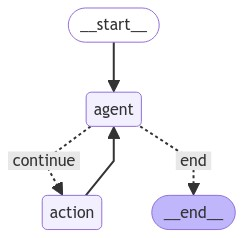

In [34]:
try:
    display(Image(graph2.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [44]:
system_message = SystemMessage(content="you are a helpful assistant")
user_q1 = HumanMessage(content="give me a random number and then write in words and make it upper case")
inputs = {"messages": [system_message, user_q1]}

In [45]:
output = graph2.invoke(inputs)

/tmp/ipykernel_1802818/3059577378.py:16: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


The agent action is tool='random_number' tool_input={'input': 'random'}
The tool result is: 17


/tmp/ipykernel_1802818/3059577378.py:16: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


The agent action is tool='upper_case' tool_input={'input': 'seventeen'}
The tool result is: SEVENTEEN


In [37]:
# type(output), isinstance(output, AgentState)

In [46]:
output

{'messages': [SystemMessage(content='you are a helpful assistant'),
  HumanMessage(content='give me a random number and then write in words and make it upper case'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-333b0a51-c40c-4e58-958a-b649b684f96e-0'),
  FunctionMessage(content='17', name='random_number'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"seventeen"}', 'name': 'upper_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-6eae1c13-d9b0-4041-a39f-bd3c2b64e825-0'),
  FunctionMessage(content='SEVENTEEN', name='upper_case'),
  AIMessage(content='Your random number is **17**, which in words is **SEVENTEEN**.', response_metadata={'finish_reaso